In [46]:
pip install tushare

Note: you may need to restart the kernel to use updated packages.


This notebook is the implementation of the Recurrent Neural Network for stock prediction. We use Tushare API for scraping and developing our dataset. To make the training process easier and shorter. We chose to train on a single stock dataset 000001.SZ, which holds about 3000 days of stock data from January 1st, 2010 to Nov 11th, 2021. The RNN consists of three layers. One LSTM and two Linear layers. We removed the Embedding layers that have been taught during the lecture since our model is training to fit in linear regression instead of classification. We did not chose to use two layer LSTM for two reasons:
1) Our dataset is kind of a small dataset, which will not fit in a too big neural network
2) Adding two LSTM layers won't make the performance better, two layers of LSTM is the most. And since we don't have that much data to train, two layers of LSTM will obviously cause an underfitting.

The LSTM layer has input dimension of size 1 and hidden size of 30 due to the way that we preprocess our dataset. The first linear layer has dimension 30 $\times$ 50 and the second linear layer has dimension 50 $\times$ 1, which is our output size, 1 single output of the stock price in the future.


For innovative thinking, there are two parts, firstly, in aspect of the data preprocessing. Instead of having a single giant dataset and dividing and creating each batch of data during the training processing, which may cause some extra computational effort. We decided to stack each sequential 30 days close price into a single cell of an array, namely, every batch of tensors have the dimension of n $\times$ 30. Secondly, normally, for stock prediction, the training will only be done on the "Close" price feature in order to prediction the future price of a stock. However, we sense that there should also have a relation  between the future price of the stock and the "Open" price. So, in this case, we decided to train on both features and compare the result of training only on the "Close" price in LSTM 

In [47]:
import tushare as ts
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import math
import time

This part down below is our tiny scrapper. By using the free version of tushare API without paying any money, we can scrape about 10 years stock data from 2010-01-01 to 2022-12-31

In [48]:
ts.set_token('293d683e83b36fad82472d9a4b4c3903d21fa6bcb85cb0cd4f4b9414')

In [49]:
pro = ts.pro_api()

Pandas from getting the raw data from the scraper

In [50]:
df = pro.daily(ts_code='000001.SZ', start_date='2010-01-01', end_date='2022-12-31')

In [51]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20211118,18.09,18.12,17.73,17.80,18.11,-0.31,-1.7118,799843.77,1430058.311
1,000001.SZ,20211117,18.15,18.30,17.98,18.11,18.22,-0.11,-0.6037,664640.38,1203859.180
2,000001.SZ,20211116,18.36,18.54,18.17,18.22,18.43,-0.21,-1.1394,601110.48,1099113.409
3,000001.SZ,20211115,18.35,18.63,18.20,18.43,18.27,0.16,0.8758,655089.99,1203764.095
4,000001.SZ,20211112,18.31,18.63,18.11,18.27,18.35,-0.08,-0.4360,957546.46,1753072.716


Data Preprocessing procedure:

1) Turn the data in order of time, put the newest in the back, the data downloaded from tushare is the latest in the front, for the convenience of preparing X,y data later

2) Only use the data of the closing price field in the data, but can also be tested more price fields, for example, volume and opening price

3) Prepare X and y data, similar to the previous, first use the closing price of the most recent trading day as the first y, and then the closing price of the 60 trading days before this trading day as X. For example, the second most recent closing price is the second y, and the closing price of 60 trading days before the latest second closing price is used as the second X, and so on.

4) Normalizing the data. Actually for this part, we firstly tried to implement our own mean standard normalization by subtracting the mean of the dataset and divide it by the standard deviation. Both values can be simply got from pandas, however, when we train it on our model, there is always a constant bias between the truth label and our prediction. So in order to predict the correct result, we use the StandardScaler() that provided by sklearn. We also found other normalization method will extremely impact the result, for example, if we choose to use max-min normalization, the prediction is almost a flatten line

In [52]:

df = df.iloc[::-1]
df.reset_index(inplace=True)


training_set = df.loc[:, ['close']]


training_set = training_set.values

sc = StandardScaler()

training_set_scaled = sc.fit_transform(training_set)

from sklearn.preprocessing import scale
x_train = []
y_train = []
for i in range(10, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-10:i])
    y_train.append(training_set_scaled[i, training_set_scaled.shape[1] - 1])
x, y = np.array(x_train), np.array(y_train)




Separating the training dataset and the testing dataset as well as their corresponding labels.

In [53]:
x_train = x[:2000]
y_train = y[:2000]

x_test = x[2000:-1]
y_test = y[2000:-1]


print(f"x_train size: {len(x_train)}")
print(f"y_train size: {len(y_train)}")
print(f"x_test size: {len(x_test)}")
print(f"y_test size: {len(y_test)}")
test_size = len(x_test)
print(test_size)
# y_test

x_train size: 2000
y_train size: 2000
x_test size: 805
y_test size: 805
805


We keep the future 10 days data for comparing our final result

In [54]:
future_ten_price = sc.inverse_transform(x[-1])
future_ten_price

array([[17.87],
       [17.64],
       [17.42],
       [17.53],
       [17.4 ],
       [18.35],
       [18.27],
       [18.43],
       [18.22],
       [18.11]])

Constructing the three layer neural network for training our model. Like was introduced in the description. The three layer RNN consists of one LSTM and two linear layers. And there are 5561 parameters for this neural network. The LSTM layer will take the h_init and c_init to collect the long-term and short-term memories. And it will pass the h_seq to the linear layer for prediction. We also tried dropout and batch_first method. The dropout layer will randomly deactivate some neurons with 0.3 possibility, since we have relatively small dataset, adding on dropout layer is a good choice


In [55]:
class three_layer_recurrent_net(nn.Module):

    def __init__(self, hidden_size):
        super(three_layer_recurrent_net, self).__init__()
        self.layer1 = nn.LSTM(    1, hidden_size, batch_first = True, dropout = 0.3, bias=True )
        self.layer2 = nn.Linear(    hidden_size , 50, bias=True  )
        self.layer3 = nn.Linear(    50, 1 , bias=True  )

        
    def forward(self, word_seq, h_init, c_init ):
        h_seq , (h_final,c_final)  =   self.layer1( word_seq , (h_init,c_init) )      
        g_seq                  =   self.layer2( h_seq )
        g_seq = F.tanh(g_seq)
        score_seq              = self.layer3(g_seq)
        
        return score_seq,  h_final , c_final

Because our dataset is relatively small, we are using cpu for training

In [56]:
device= torch.device("cpu")
print(device)

cpu


This part is for converting the training and testing data to tensor and initializing some hyper parameters. 
bs: the batch size for each epoch. We are using bs 1 is because we stacked the totally 30 data into one cell, and since we do not have that much data, making a relatively small batch size may help the LSTM to learn better.
hidden_size: this depends on the number of datas in a single batch. For us, each batch is made of 30 days data, there fore, the dimension of the tensor will be 1 $\times$ 30
net: the instance of our LSTM.

We pass the network to the cpu (although little bit of redundant)

In [57]:
train_data = torch.Tensor(x_train)



train_label = torch.Tensor(y_train)

# print(train_label.size())

test_data = torch.Tensor(x_test)

# test_data = test_data.permute(1, 0, 2)

test_label = torch.Tensor(y_test)

bs =1

hidden_size=30

net = three_layer_recurrent_net( hidden_size )
print(net.layer1)

net = net.to(device)

# print(train_data.size())
train_label.size()
train_label

LSTM(1, 30, batch_first=True, dropout=0.3)


/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


tensor([ 1.8622,  2.0566,  1.8392,  ..., -1.2990, -1.2197, -1.2248])

Initializing the weight of the two linear layers. Found it actually helps to generate a better result.

In [58]:
net.layer2.weight.data.uniform_(-0.1, 0.1)
net.layer3.weight.data.uniform_(-0.1, 0.1)

tensor([[-0.0408, -0.0481,  0.0873,  0.0862, -0.0456,  0.0183, -0.0757, -0.0645,
          0.0852,  0.0594,  0.0182, -0.0625,  0.0782,  0.0699,  0.0365,  0.0894,
          0.0049, -0.0329, -0.0283, -0.0049, -0.0148,  0.0267,  0.0011,  0.0486,
          0.0232, -0.0825, -0.0489, -0.0589,  0.0715,  0.0429,  0.0030,  0.0548,
          0.0682,  0.0584,  0.0550, -0.0617, -0.0624, -0.0907,  0.0642,  0.0892,
         -0.0175,  0.0609, -0.0270,  0.0940,  0.0634,  0.0492, -0.0475,  0.0542,
          0.0321, -0.0207]])

Initializing the the Mean Square Loss for criterion and set the hyper parameter learning rate to be 0.01

In [59]:
criterion = nn.MSELoss()

# my_lr = 0.1851851851851852 	
my_lr =0.25

Do 20 epochs on the training process and dividing the learning rate by 2 after the third epoch just following what Professor Xavier has done during the lecture. We count the loss for each epoch and sum it up to check the final total loss. During the whole building process, we tried different criterions such as Adam, Adamw and SDG. AdamW and Adam can converge in a relatively short time, but the model does not generalize well on our test data. After several choices, we figured out that SDG is our best choice.

In [60]:
start=time.time()


loss_epochs = []

for epoch in range(20):

    # divide the learning rate by 3 except after the first epoch
    if epoch >= 3:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   

    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    
       
    # set the initial h and c to be the zero vector
    h = torch.zeros(1, bs, hidden_size)
    c = torch.zeros(1, bs, hidden_size)

 
    h=h.to(device)
    c=c.to(device)

    for count in range(0,  2000 - 1  ,bs):
        # Set the gradients to zeros
        optimizer.zero_grad()
        # create a minibatch
        minibatch_data =  train_data[ count   : count+bs ]
        minibatch_label = train_label[count: count +bs]  
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        # Detach to prevent from backpropagating all the way to the beginning
        # Then tell Pytorch to start tracking all operations that will be done on h and c
        h=h.detach()
        c=c.detach()
        h=h.requires_grad_()
        c=c.requires_grad_()
        # forward the minibatch through the net
        scores, h, c  = net( minibatch_data, h , c)
        # reshape the scores and labels to huge batch of size bs*seq_length
        scores          =          scores[-1]
        minibatch_label =   minibatch_label    
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(  scores ,  minibatch_label )
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()
        # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
        optimizer.step()
        # update the running loss  
        running_loss += loss.item()
        num_batches += 1
        
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    loss_epochs.append(total_loss)
    elapsed = time.time()-start
    
    print('')
    print('epoch=',epoch, '\t time=', elapsed,'\t lr=',   my_lr , '\t loss=',  total_loss)
#     eval_on_test_set()




/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



epoch= 0 	 time= 4.800110816955566 	 lr= 0.25 	 loss= 0.013313513600303434

epoch= 1 	 time= 9.442927837371826 	 lr= 0.25 	 loss= 0.02250199170044037

epoch= 2 	 time= 13.94291090965271 	 lr= 0.25 	 loss= 0.018747673021379096

epoch= 3 	 time= 18.34182572364807 	 lr= 0.125 	 loss= 0.030401888082999175

epoch= 4 	 time= 23.00395965576172 	 lr= 0.0625 	 loss= 0.05571821437631879

epoch= 5 	 time= 27.81911873817444 	 lr= 0.03125 	 loss= 0.08316625125296483

epoch= 6 	 time= 32.491336822509766 	 lr= 0.015625 	 loss= 0.06617666969675154

epoch= 7 	 time= 37.16544485092163 	 lr= 0.0078125 	 loss= 0.0500182203600999

epoch= 8 	 time= 41.70264291763306 	 lr= 0.00390625 	 loss= 0.04923913801118441

epoch= 9 	 time= 46.206899881362915 	 lr= 0.001953125 	 loss= 0.04879726221872278

epoch= 10 	 time= 50.611013889312744 	 lr= 0.0009765625 	 loss= 0.04737305962444675

epoch= 11 	 time= 55.19320487976074 	 lr= 0.00048828125 	 loss= 0.045978063760146556

epoch= 12 	 time= 60.043609857559204 	 lr= 0.0

Plot the loss in here, and we can see clearly that the loss increase first and then decrease from the fifth epoch, so the best learning rate could be around 0.03

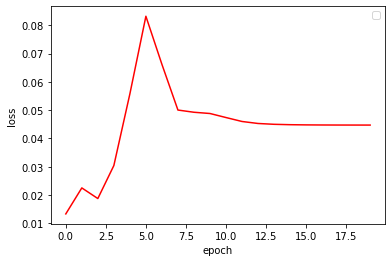

In [61]:
import matplotlib.pyplot as plt

plt.plot(loss_epochs, color = 'red', label = '')

plt.xlabel('epoch')

plt.ylabel('loss')

plt.legend()

plt.show()

In [62]:
prediction = []

def eval_on_test_set():


    running_loss=0
    num_batches=0    
       
    h = torch.zeros(1, bs, hidden_size)
    c = torch.zeros(1, bs, hidden_size)
   
    h=h.to(device)
    c=c.to(device)
       
    for count in range( 0 , test_size ,  1) :
               
        minibatch_data =  test_data[ count   : count+bs ]
        minibatch_label = test_label[count : count+bs] 
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
                                  
#         print(minibatch_data.size())
        scores, h, c  = net( minibatch_data, h , c)
        
        minibatch_label =   minibatch_label
        scores          =            scores[-1]
        
#         print(f"score: {scores}")

        

#         print(f" score: {scores} score size: {scores.size()} mini_batch size: {minibatch_label.size()}")
        
        loss = criterion(  scores ,  minibatch_label )    
        
        h=h.detach()
        c=c.detach()
            
        running_loss += loss.item()
        num_batches += 1   
        scores = scores.detach().numpy()
        
        scores = sc.inverse_transform(scores)
        #print(scores)
        prediction.append(scores[0])
#         prediction.append(scores[0])
    total_loss = running_loss/num_batches 
    print('test: loss = ', total_loss )

The total loss of the evaluation is around 0.08 by only training on the "Close feature" and we tried to train on both "Close" and "Open" feature together since we thought there is a co-relationship between them, however, after same 20 epochs, the loss of training on both "Close" and "Open" feature give us a relatively higher loss. So we decided to remove the "Opening feature". And we can visualize the result in the figure below.

In [63]:
eval_on_test_set()

test: loss =  0.06104416957928406


But overall, you can see that the two curves, namely the predictions from the model and its true labels has the same trends in general, so the model is still generalizable for predicting whether the stock will increase the value of decrease.

Testing result (only on close value) under normalization range. We can clearly see that the prediction line (in green) has a very high degree of fitness with the ground truth label of the test set.

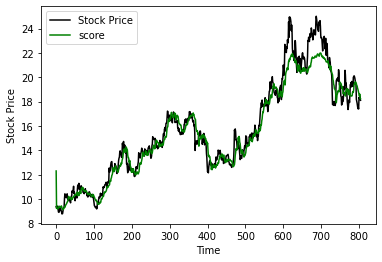

In [64]:
#import matplotlib.pyplot as plt

plt.plot(sc.inverse_transform(test_label), color = 'black', label = 'Stock Price')
plt.plot(prediction, color='green', label = 'score')

plt.xlabel('Time')

plt.ylabel('Stock Price')

plt.legend()

plt.show()

Similary testing result for training on two feature (Open and Close values), gives us relatively same result

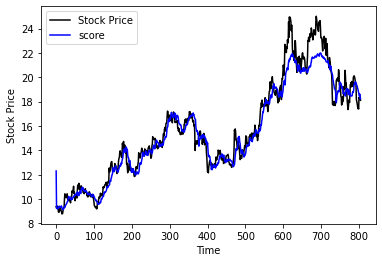

In [65]:
import matplotlib.pyplot as plt




plt.plot(sc.inverse_transform(test_label.view(test_size,1)), color = 'black', label = 'Stock Price')
plt.plot(prediction, color='blue', label = 'score')

plt.xlabel('Time')

plt.ylabel('Stock Price')

plt.legend()

plt.show()


Preparing for plotting the future 10 days stock price.

In [66]:
test_label_1 = []
for i in torch.tensor(sc.inverse_transform(test_label.view(test_size,1)))[-9:].view(1,9).numpy().tolist()[0]:
    test_label_1.append(i)
test_label_1.append(float(prediction[-1]))

In [67]:
predict = test_label_1
h = torch.zeros(1, bs, hidden_size)
c = torch.zeros(1, bs, hidden_size)
   
for i in range(0,len(test_label_1)):
    test_ = torch.tensor([test_label_1[i:i+10]]).unsqueeze(0).permute(0,2,1)
    test_ = test_.to(device)
    scores,h,c  = net(test_, h, c)
    scores = scores[0][-1]
    scores = scores.detach().numpy()
    test_label_1.append(float(sc.inverse_transform(scores)))

/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


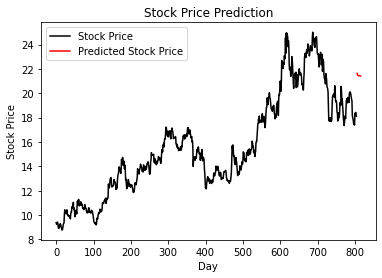

In [68]:
day = []
for i in range(len(test_label_1)-10):
        day.append(test_size+1+i)
plt.plot(sc.inverse_transform(test_label.view(test_size,1)), color = 'black', label = 'Stock Price')
plt.plot(day,test_label_1[10:], color = "red", label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Conclusion:  We implemented a simple accuracy testing method which takes our prediction result and the ground truth test label as input. We have set a threshold 1.5,which means if the difference between any two close price pairs is lower than 1.5 yuan, we count it as matched. By comparing and computing the difference between each price data pair, we got the accuracy 91% of making predictions of stock on the LSTM neural network. And by comparing and contrasting with MLP and CNN (both have accuracy around 40%), LSTM definitely shows its better performance on time sequential co-relationship data. We tried to predict the future 10 days of the stock price. Since we cannot actually get the future price, when dividing the test data, we keep 10 days actual value for checking the prediction ability. Although the overall accuracy on the test dataset already proves the performance, comparing the actual value will make the experiment much more interesting. Below, are the result of the real price and the price we predicted, and also the plot of both data, we can see that the difference between the two data will not surpass 2, which should be a fairly accuracy model due to the limited amount of data we have


In [69]:
future_ten_price

array([[17.87],
       [17.64],
       [17.42],
       [17.53],
       [17.4 ],
       [18.35],
       [18.27],
       [18.43],
       [18.22],
       [18.11]])

In [70]:
test_label_1[10:]

[21.630779266357422,
 21.494083404541016,
 21.466064453125,
 21.449804306030273,
 21.4411563873291,
 21.43644142150879,
 21.433799743652344,
 21.432315826416016,
 21.431455612182617,
 21.430950164794922]

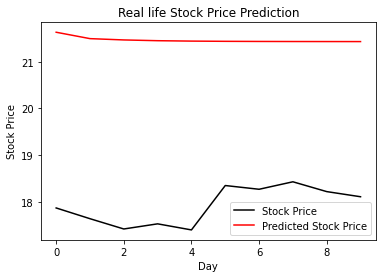

In [71]:
plt.plot(future_ten_price, color = 'black', label = 'Stock Price')
plt.plot(test_label_1[10:], color = "red", label = 'Predicted Stock Price')
plt.title('Real life Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [72]:
def get_error( scores , labels ):

    bs=len(scores)
    matches = 0.0
    
    for i in range (len(scores)):
        if abs(scores[i] - labels[i]) <=1.5:
            matches+=1
    
    return matches/bs

In [73]:
labels = sc.inverse_transform(test_label.view(test_size,1))
acccuracy = get_error(prediction, labels)

In [74]:
print(f"acccuracy : {acccuracy}")

acccuracy : 0.8906832298136645


In [75]:
df = pro.daily(ts_code='000001.SZ', start_date='2020-1-1', end_date='2023-1-1')